Watch these explanations first:

https://www.youtube.com/watch?v=96b_weTZb2w&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=33

https://www.youtube.com/watch?v=6jfw8MuKwpI&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=34

https://www.youtube.com/watch?v=d2XB5-tuCWU&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=35

https://www.youtube.com/watch?v=0NSLgoEtdnw&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=36

Reference also: 

http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

https://openaccess.thecvf.com/content_cvpr_2014/papers/Taigman_DeepFace_Closing_the_2014_CVPR_paper.pdf 

In [1]:
#from sklearn.datasets import fetch_olivetti_faces
!wget -O detection.zip  -q https://1drv.ms/u/s!AhnVhbVlzYkKefNEW0kxes195mQ?e=MV3Qaz #https://onedrive.live.com/?authkey=%21APNEW0kxes195mQ&cid=0A89CD65B585D519&id=A89CD65B585D519%21121&parId=A89CD65B585D519%21103&action=locate
!unzip -q detection.zip 
!rm detection.zip

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.setrecursionlimit(10000)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, folder, transform=None, should_invert=True):
        self.folder = folder
        self.items = glob(f'{self.folder}/*/*') 
        self.transform = transform  

    #Next we are taking two images and the 0 or 1 based on if they belong to same person or not.
    def __getitem__(self, ix):
        itemA = self.items[ix]
        person = itemA.split("/")[-2]         
        same_person = np.random.randint(2)   
        if same_person:
            itemB = glob(f'{self.folder}/{person}/*')
            key = np.random.randint(len(itemB))
            itemB = itemB[key]
        else:
            while True:
                itemB = self.items                   
                key = np.random.randint(len(itemB))
                itemB = itemB[key]
                if person != itemB.split("/")[-2]:   
                    break
                    
        imgA = cv2.imread(itemA, cv2.IMREAD_GRAYSCALE)   
        imgB = cv2.imread(itemB, cv2.IMREAD_GRAYSCALE)  
        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)
        return imgA, imgB, np.array([1-same_person])
    def __len__(self):
        return len(self.items)


In [3]:
trn_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, (0.01,0.2),
                            scale=(0.9,1.1)),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trn_ds = SiameseNetworkDataset(folder="./data/faces/training/", transform=trn_tfms)
val_ds = SiameseNetworkDataset(folder="./data/faces/testing/", transform=val_tfms)

trn_dl = DataLoader(trn_ds, shuffle=True, batch_size=64, drop_last=True)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=64, drop_last=True)

In [5]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1, padding_mode='reflect'),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
    )

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.features = nn.Sequential(
            convBlock(1,4),
            convBlock(4,8),
            convBlock(8,8),
            nn.Flatten(),
            nn.Linear(8*100*100, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 5)
        )

    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

In [7]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        acc = ((euclidean_distance > 0.6) == label).float().mean()
        return loss_contrastive, acc

def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    return loss.item(), acc.item()

In [8]:
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [9]:
n_epochs = 5          
history = {'trainloss':[], 'trainaccuracy':[], 'validloss':[], 'validccuracy':[]}

for epoch in range(n_epochs):
    
    for i, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion) 
        history['trainloss'].append(loss)
        history['trainaccuracy'].append(acc)

    for i, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        history['validloss'].append(loss)
        history['validccuracy'].append(acc)

    if epoch==10: 
      optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

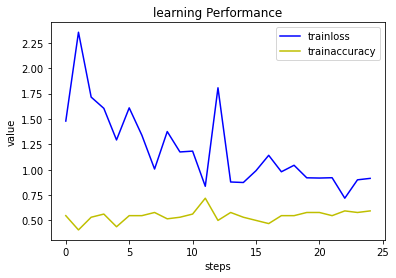

In [21]:
def plot_scores(history):

  plt.plot(history['trainloss'], '-b')           # plt.plot(history['validloss'], '-c')
  plt.plot(history.get('trainaccuracy'), '-y')   # plt.plot(history.get('validccuracy'), '-m')

  plt.legend(['trainloss', 'trainaccuracy'])     #, 'validloss', 'validaccuracy'
  plt.xlabel('steps')
  plt.ylabel('value')
  plt.title('learning Performance');

plot_scores(history)

Different


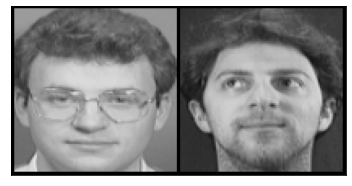

Same Face


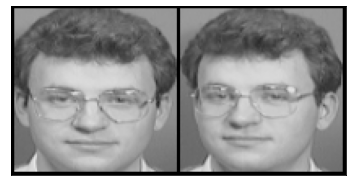

In [24]:
model.eval()
val_dl = DataLoader(val_ds, num_workers=0, batch_size=1, shuffle=True)
dataiter = iter(val_dl)
x0, _, _ = next(dataiter)

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


for i in range(2):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0*0.5+0.5, x1*0.5+0.5),0)
    output1, output2 = model(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    output = 'Same Face' if euclidean_distance.item() < 0.6 else 'Different'
    print(output)
    show(make_grid(concatenated))
    plt.show()